# Imports

In [1]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
import sklearn  as skl
import time
from IPython.display import clear_output
# import scikitplot as skplt

from sklearn import pipeline      # Pipeline, make_pipeline
from sklearn import preprocessing # StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import inspection      # permutation_importance

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
sb.set_style("whitegrid")
skl.set_config(display='diagram')

print("Pandas  ", pd.__version__)
print("Sklearn ", skl.__version__)

Pandas   1.2.0
Sklearn  0.23.2


In [3]:
########################################################### CLASSIFIERS

#### MULT
from sklearn.linear_model   import LogisticRegression
from sklearn.linear_model   import RidgeClassifier
from sklearn.svm            import SVC
from sklearn.svm            import NuSVC
from sklearn.svm            import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes    import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble       import StackingClassifier

#### TREE
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier, plot_tree
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier
#from ngboost               import NGBClassifier
#from rgf.sklearn           import RGFClassifier, FastRGFClassifier

########################################################### REGRESSORS
from sklearn.linear_model  import ElasticNet, Ridge, Lasso, BayesianRidge, ARDRegression, TweedieRegressor
from sklearn.svm           import LinearSVR, NuSVR, SVR
from sklearn.ensemble      import BaggingRegressor
from sklearn.kernel_ridge  import KernelRidge

# DATA

### Read data

In [4]:
df      = pd.read_csv("../../datasets/titanic_train.csv", index_col='PassengerId')
df_test = pd.read_csv("../../datasets/titanic_test.csv",  index_col='PassengerId')

### Select data for experiment

In [5]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

# PREPROCESSING

### Select numerical and categorical variables

In [6]:
cat_vars  = x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Categorical features:
 ['Sex', 'Embarked']


### Preprocessing for Mult Models

In [11]:
num_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='mean', add_indicator=True)), # mean, median
    ('scaler', preprocessing.StandardScaler())
])

cat_4_multModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', preprocessing.OneHotEncoder(handle_unknown='ignore'))
])

mult_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_multModels, num_vars),
    ('cat', cat_4_multModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

mult_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex', 'Embarked'])])

### Preprocessing for Tree Models

In [16]:
num_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=-9999)),
])

cat_4_treeModels = pipeline.Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', preprocessing.OrdinalEncoder()) # handle_unknown='ignore' ONLI IN VERSION 0.24
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=-9999,
                                                                strategy='constant'))]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

# Models

In [19]:
"""
ensemble = [
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    make_pipeline(StandardScaler(), RidgeClassifier()),
    make_pipeline(StandardScaler(), LinearSVC(random_state=42))
]

ensemble2 = [
    ('RF',    RandomForestClassifier(n_estimators=50, random_state=42)),
    ("Ridge", make_pipeline(StandardScaler(), RidgeClassifier())),
    ("SVM_rbf", make_pipeline(StandardScaler(), SVC(kernel='linear')))
]
"""

mult_classifiers = {
  #"Stacking":           StackingClassifier(estimators=ensemble2, final_estimator=LogisticRegression()),
  "LogRegr l1 liblin":  LogisticRegression(penalty='l1', solver='liblinear', tol=1e-6, max_iter=int(1e6), warm_start=True, intercept_scaling=10000.),
  "LogRegr l2 lbfgs":   LogisticRegression(penalty='l2', solver='lbfgs', n_jobs=-1),
  "LogRegr l1 saga":    LogisticRegression(penalty='l1', solver='saga', tol=0.01, n_jobs=-1),
  "LogRegr l2 saga":    LogisticRegression(penalty='l2', solver='saga', tol=0.01, n_jobs=-1),
  "LogRegr elasticnet": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, tol=0.01, n_jobs=-1),
  "Ridge 1.":           RidgeClassifier(alpha=1.),
  "Ridge .5":           RidgeClassifier(alpha=.5),
  "Ridge .1":           RidgeClassifier(alpha=.1),
  "Ridge .01":          RidgeClassifier(alpha=.01),
  "Ridge .001":         RidgeClassifier(alpha=.001),
  "Ridge .0001":        RidgeClassifier(alpha=.0001),
  "Ridge .00001":       RidgeClassifier(alpha=.00001),
  "SVM_lin":            SVC(kernel="linear", C=0.025),
  "SVM_rbf":            SVC(kernel='rbf'),
  "NuSVC":              NuSVC(),
  "LinearSVC":          LinearSVC(),
  "KNN3":               KNeighborsClassifier(3),
  "KNN5":               KNeighborsClassifier(5),
# "GP":                 GaussianProcessClassifier(1.0 * RBF(1.0)),
  "GaussianNB":         GaussianNB()
}

tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees":   ExtraTreesClassifier(n_estimators=100, n_jobs=-1),
  "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
# "AdaBoost":      AdaBoostClassifier(n_estimators=100),
# "Skl GBM":       GradientBoostingClassifier(n_estimators=100),
# "Skl HistGBM":   HistGradientBoostingClassifier(),
  "XGBoost":       XGBClassifier(n_estimators=100, n_jobs=-1),
  "LightGBM":      LGBMClassifier(n_estimators=100, n_jobs=-1),
# "CatBoost":      CatBoostClassifier(n_estimators=100),
# "NGBoost":       NGBClassifier(n_estimators=100),
# "RGF":           RGFClassifier(n_jobs=-1),
# "FastRGF":       FastRGFClassifier())
}


mult_classifiers = {name: pipeline.make_pipeline(mult_prepro, model) for name, model in mult_classifiers.items()}
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in mult_classifiers.items()}


models = {**mult_classifiers, **tree_classifiers}

In [8]:
mult_regressors = {
  "lasso":          Lasso(     alpha = 1, normalize = False, max_iter = 5000, tol = 1e-5),
  "ridge":          Ridge(     alpha = 1, normalize = False, max_iter = 5000, tol = 1e-5),
  "elastic_net":    ElasticNet(alpha =1, normalize = False, max_iter = 5000, tol = 1e-5, l1_ratio = 0.5),
  "bagging_regr":   BaggingRegressor(Ridge(alpha=1), n_estimators=100, random_state=42, max_samples=3, max_features=6),
  "bayesian_ridge": BayesianRidge(n_iter=1000, tol=10e-05),
  "ard_regression": ARDRegression(),
  "kernel_ridge":   KernelRidge(alpha=1, kernel='rbf'),
  "linear_svr":     LinearSVR(C=1),
  "svr":            SVR(C=1, cache_size=3000.0),
  "nusvr":          NuSVR(nu=1, C=1),
  "GLM power0":     TweedieRegressor( power = 0, alpha = 1),
  "GLM power1":     TweedieRegressor( power = 1, alpha = 1),
  "GLM power2":     TweedieRegressor( power = 2, alpha = 1)
}

# Do the experiment

In [22]:
preds = {}
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

for name, model in models.items():    
    #cv_r = cross_val_score(model, x, y, cv=skf, scoring='accuracy')
        
    start_time = time.time()
    pred = cross_val_predict(model, x, y, cv=skf)
    total_time = time.time() - start_time
    
    preds[name] = pred
    results = results.append({"Model":    name,
                              "Accuracy": accuracy_score(y, pred)*100,
                              "Bal Acc.": balanced_accuracy_score(y, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
    
    results_ord = results.sort_values(by=['Bal Acc.'], ascending=False, ignore_index=True)
    results_ord.index += 1 

    clear_output(wait=True)
    #display(results_ord.style.background_gradient(subset=['Accuracy', "Bal Acc.", 'Time'], cmap='Greens'))
    display(results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d'))

NameError: name 'cross_val_predict' is not defined

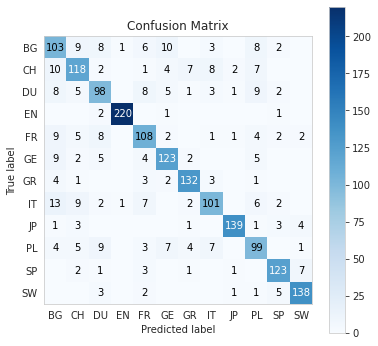

In [10]:
#skplt.metrics.plot_confusion_matrix(y, preds["Ridge 1."], normalize=False, hide_zeros=True, figsize=(6, 6));
skplt.metrics.plot_confusion_matrix(y, preds["LogRegr l1 liblin"], normalize=False, hide_zeros=True, figsize=(6, 6));

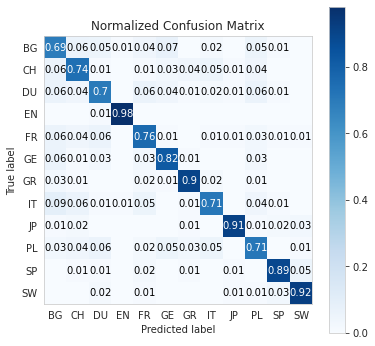

In [12]:
#skplt.metrics.plot_confusion_matrix(y, preds["Ridge 1."], normalize=True, hide_zeros=True, figsize=(6, 6));
skplt.metrics.plot_confusion_matrix(y, preds["LogRegr l1 liblin"], normalize=True, hide_zeros=True, figsize=(6, 6));

In [14]:
preds_df = pd.DataFrame(preds)
preds_df["Target"] = y
preds_df.head()

,LogRegr l1 liblin,LogRegr l2 lbfgs,LogRegr l1 saga,LogRegr l2 saga,LogRegr elasticnet,Ridge 1.,Ridge .5,Ridge .1,Ridge .01,Ridge .001,Ridge .0001,Ridge .00001,SVM_lin,SVM_rbf,NuSVC,LinearSVC,KNN3,KNN5,GaussianNB,Decision Tree,Extra Trees,Random Forest,XGBoost,LightGBM,Target
0,EN,EN,EN,EN,EN,PL,PL,PL,PL,PL,PL,PL,BG,EN,EN,EN,BG,BG,GE,CH,BG,BG,BG,BG,BG
1,GE,GE,GE,GE,GE,DU,DU,DU,DU,DU,DU,DU,GE,GE,GE,GE,FR,FR,GE,IT,BG,GE,DU,DU,BG
2,GE,GE,GE,GE,GE,BG,BG,BG,BG,BG,BG,BG,GE,GE,GE,BG,FR,BG,GE,FR,GE,GE,BG,BG,BG
3,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,FR,SP,GE,GE,BG,BG,BG,BG,BG
4,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,BG,FR,FR,BG,DU,BG,GE,PL,PL,BG


In [16]:
#preds_df.corr()
#corr_df = preds_df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

def categ_corr(df):
    corr = pd.DataFrame()
    for a in list(df.columns.values):
        for b in list(df.columns.values):
            corr.loc[a, b] = (df[a]==df[b]).sum()/len(df)
    return corr

ccorr = categ_corr(preds_df)

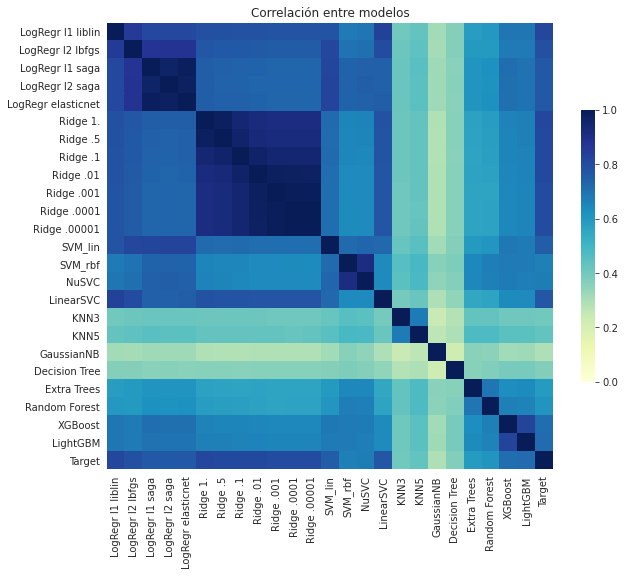

In [17]:
fig, ax = plt.subplots(figsize=(10,10)) 
sb.heatmap(
    ccorr, 
    #mask=np.triu(np.ones_like(ccorr, dtype=np.bool)),
    vmin=0, vmax=1,
    cmap="YlGnBu",#sb.diverging_palette(20, 220, n=200),
    square=True,
    #linewidths=.4,
    cbar_kws={"shrink": .5},
    #annot=True, fmt=".0%"
).set_title("Correlación entre modelos");

# Analisis POR PARTES de la entrevista

In [7]:
models = {
    "Ridge (alp=1.)": make_pipeline(StandardScaler(), RidgeClassifier()),
    "RF (trees=50)":  RandomForestClassifier(n_estimators=50, random_state=42)
}

results = pd.DataFrame()

def analisis_por_partes_entrevista(df, models, n_folds=20):
    
    for P in ["P1", "P2", "P3"]:
        x_parte = x[parte==P] # parte es una pd.serie, P es un string
        y_parte = y[parte==P]
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)

        for modelname, model in models.items():
            pred = cross_val_predict(model, x_parte, y_parte, cv=skf)
            bal_acc = balanced_accuracy_score(y_parte, pred)*100
            results.at[P, modelname] = bal_acc
            
            clear_output(wait=True)
            display(results.style.bar(vmin=0, vmax=100, color='#5fba7d'))

analisis_por_partes_entrevista(df_lex_simp, models)

,Ridge (alp=1.),RF (trees=50)
P1,45.838176,40.758605
P2,45.661236,43.373359
P3,42.027858,34.898199


# <center> Interpretability

## Linear models: `coef_` & `intercept_`

In [7]:
best_model = RidgeClassifier(alpha=1.)
best_model.fit(x,y)

/usr/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.2219e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


RidgeClassifier()

In [8]:
best_model.coef_.shape

(12, 363)

In [9]:
coef_df = pd.DataFrame(np.transpose(best_model.coef_), index=x.columns, columns=best_model.classes_)
coef_df["General"] = coef_df.abs().sum(axis=1)
coef_df

,BG,CH,DU,EN,FR,GE,GR,IT,JP,PL,SP,SW,General
av_nominal_deps,1.255252e-01,5.378094e-02,1.712944e-01,-4.670543e-01,1.891678e-01,-1.523711e-01,-1.653310e-01,2.568726e-01,-9.682658e-02,2.802780e-01,7.418874e-02,-2.695247e-01,2.302215
av_nsubj_deps,2.053347e-02,-2.218208e-02,-3.928979e-01,5.050360e-01,2.211988e-01,1.290338e-01,-2.572903e-02,1.039127e-02,-2.451435e-01,-1.728166e-01,1.785945e-01,-2.060187e-01,2.129576
av_nsubj_pass_deps,1.570224e-02,1.705684e-02,8.870050e-02,-5.305149e-02,-5.017186e-02,-3.214557e-02,-2.992781e-02,6.062454e-02,7.939354e-03,-3.476545e-02,7.459102e-03,2.579596e-03,0.400124
av_agents_deps,-8.292681e-02,-1.442681e-02,9.337256e-02,-1.077426e-01,1.895112e-02,7.129774e-03,1.332901e-01,-4.091545e-02,-3.918143e-02,-9.377699e-03,-3.651719e-02,7.834442e-02,0.662176
av_dobj_deps,-1.407838e-01,-1.224941e-01,-1.616151e-01,-1.933588e-01,2.715864e-01,-3.321795e-02,4.437680e-02,-1.473999e-02,-1.705340e-02,-1.941284e-01,3.358623e-01,2.255661e-01,1.754783
av_pobj_deps,-9.289794e-02,4.539627e-03,-1.478125e-01,-1.648199e-01,2.309004e-01,1.013916e-01,-4.205655e-02,4.371124e-02,-8.326181e-02,4.542735e-02,-1.260117e-02,1.174796e-01,1.086900
av_iobj_deps,5.228567e-02,-6.585497e-02,-4.551442e-02,2.395416e-01,-5.392441e-02,-1.003280e-01,-7.977055e-02,-5.108128e-02,-8.812278e-02,2.303442e-01,-2.038248e-01,1.662498e-01,1.376842
av_ncomp_deps,-1.043196e-03,3.957938e-03,4.761757e-03,-4.326538e-02,4.173094e-02,2.069537e-02,2.451650e-02,-3.274398e-02,-2.916433e-02,-1.365397e-02,2.439233e-02,-1.839821e-04,0.240110
av_nominal_deps_NN,1.033405e-01,6.192476e-02,1.043364e-02,3.234372e-01,-3.004987e-01,2.448100e-01,-1.506538e-01,-1.894315e-01,3.140933e-01,-1.943316e-01,-1.437575e-01,-7.936630e-02,2.116079
av_nsubj_deps_NN,-1.663414e-01,-6.083361e-02,-7.883047e-02,2.116747e-01,8.177161e-02,-6.894262e-02,3.838446e-02,9.616230e-02,4.933925e-02,-7.418250e-02,1.176015e-01,-1.458032e-01,1.189868


In [10]:
def linear_coefs_per_class(idioma, pos=10, neg=10):
    coef_idioma = coef_df[idioma].sort_values()
    coef_idioma = coef_idioma.head(neg).append(coef_idioma.tail(pos))
    
    coef_idioma.plot(kind="barh")
    plt.title("Linear feature importance of "+idioma)
    plt.show()

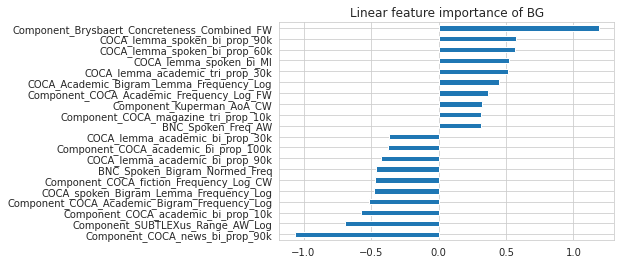

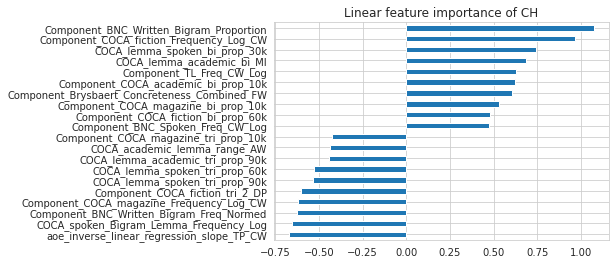

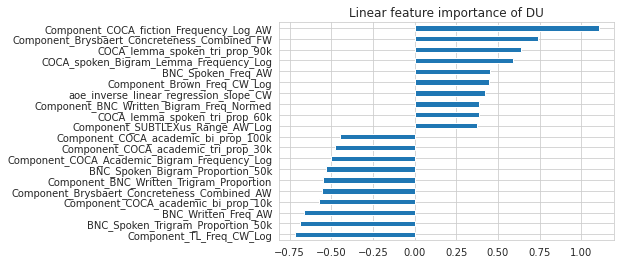

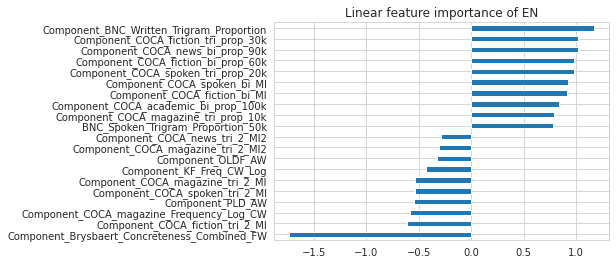

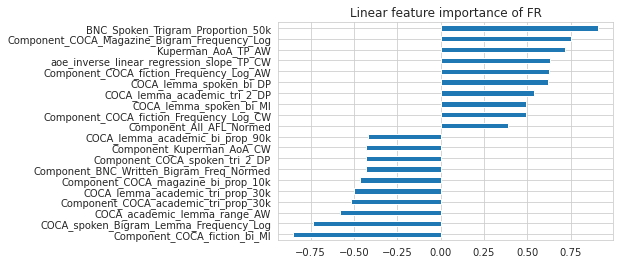

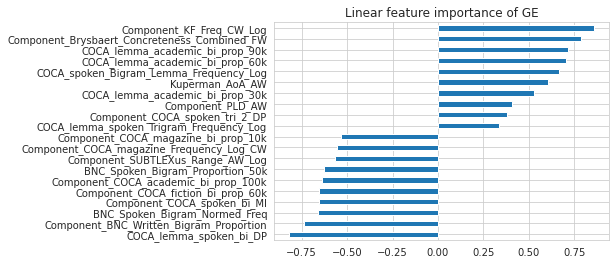

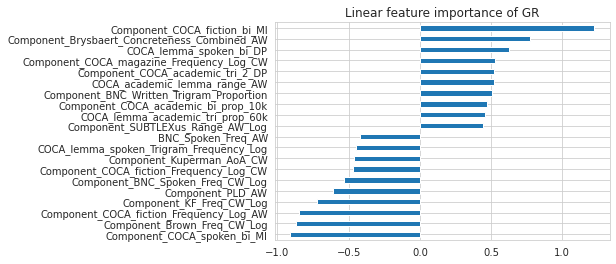

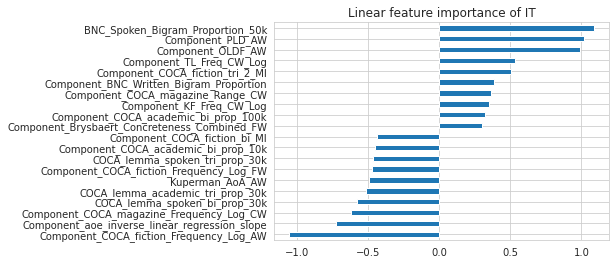

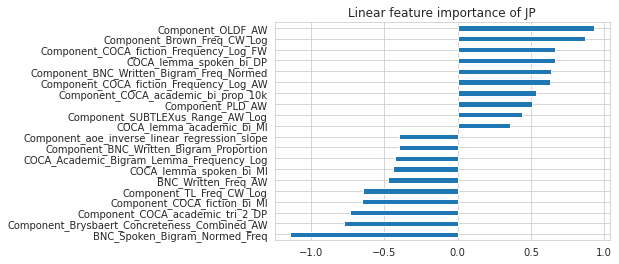

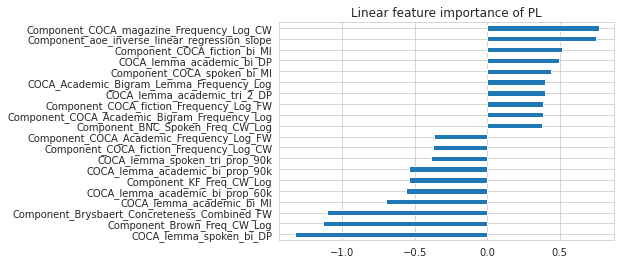

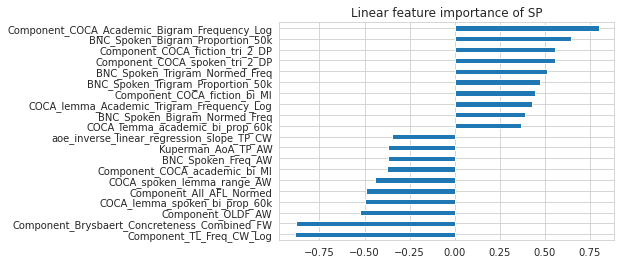

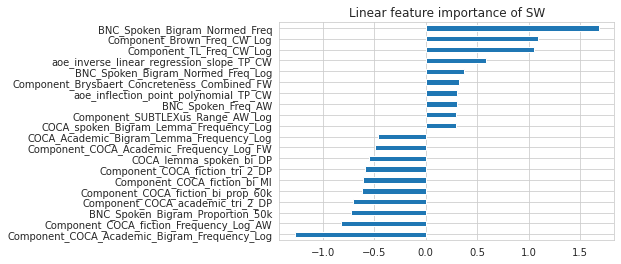

In [11]:
for clas in best_model.classes_:
    linear_coefs_per_class(clas, pos=10, neg=10)

In [10]:
# Compute Permutation Feature Importance
pfi = permutation_importance(best_model, x, y, n_repeats=10, random_state=0, n_jobs=-1)

# Clean data
sorted_idx = pfi.importances_mean.argsort()[::-1]
pfi_df = pd.DataFrame(data=pfi.importances[sorted_idx].T, columns=x.columns[sorted_idx])

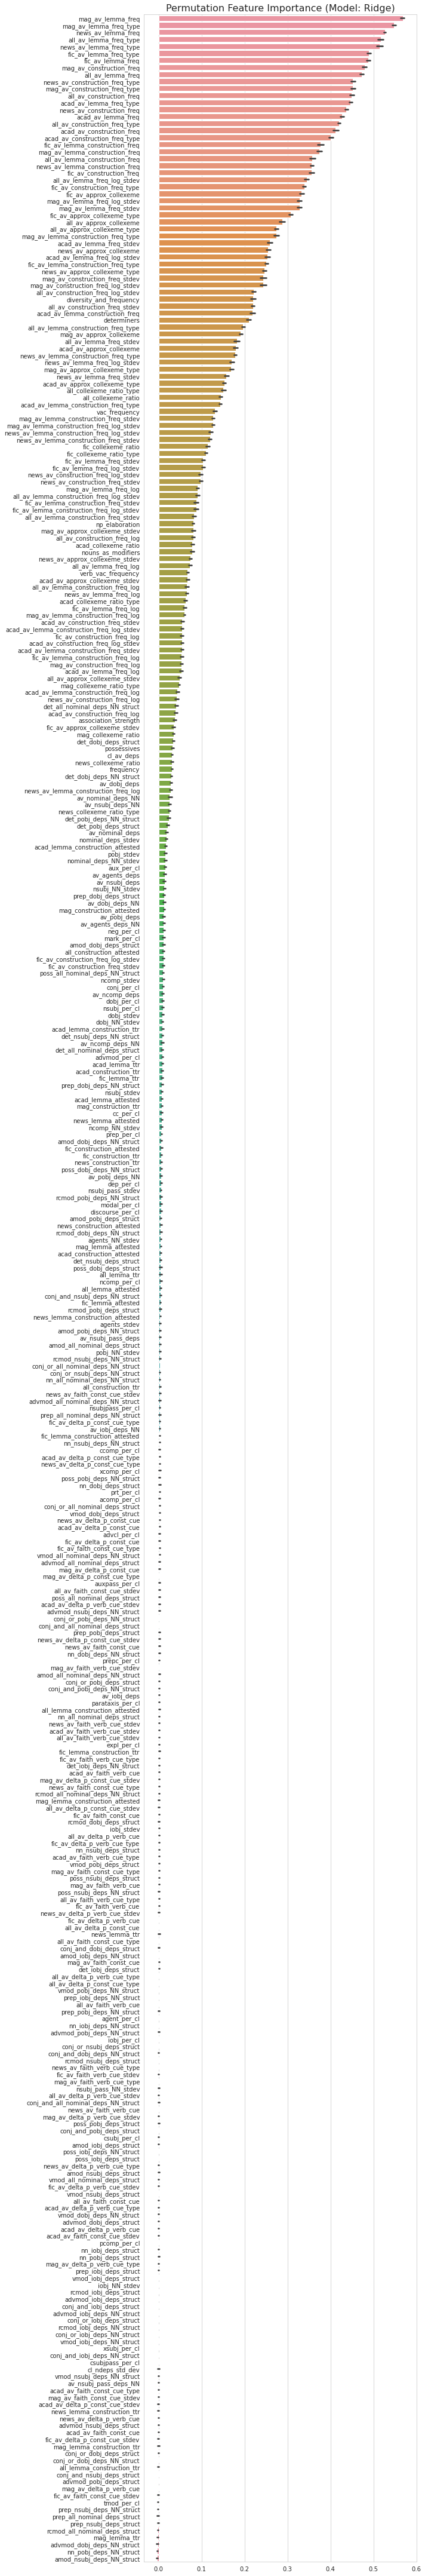

In [11]:
plt.figure(figsize=(10, 60))
sb.barplot(data=pfi_df, orient="h").set_title("Permutation Feature Importance (Model: Ridge)", fontsize=16);
plt.tight_layout()

In [12]:
model = LGBMClassifier()
model.fit(x,y)

LGBMClassifier()

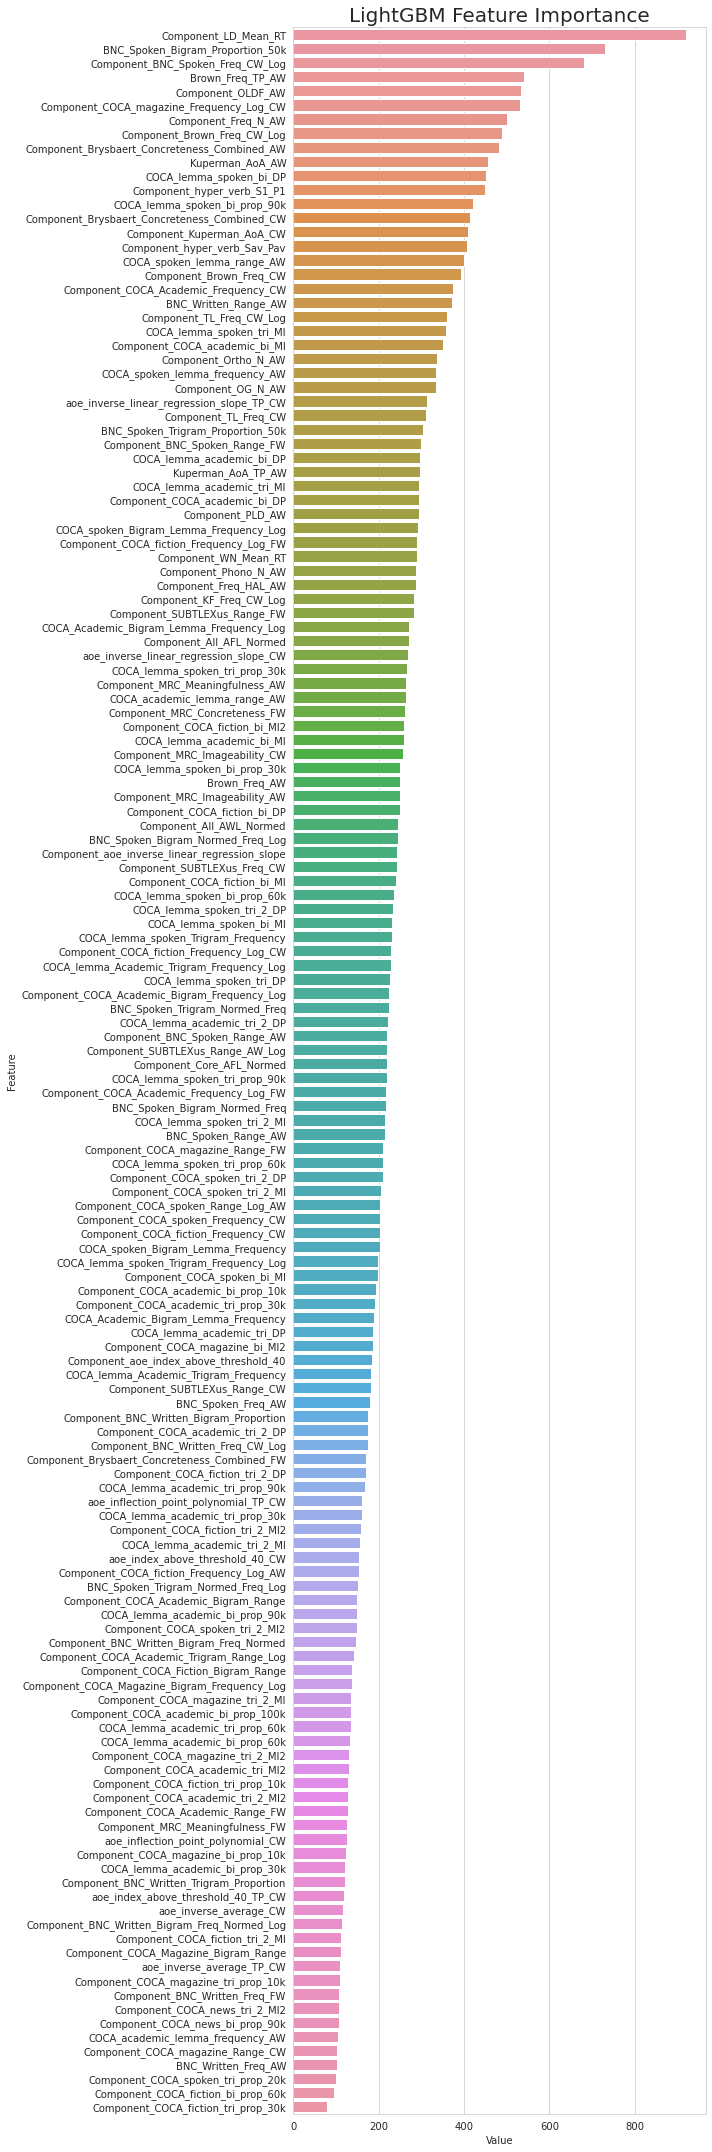

In [27]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,x.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 30))
sb.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance', fontsize=20)
plt.tight_layout()
plt.show()

In [14]:
# Compute Permutation Feature Importance
pfi = permutation_importance(model, x, y, n_repeats=10, random_state=0, n_jobs=-1)

# Clean data
sorted_idx = pfi.importances_mean.argsort()[::-1]
pfi_df = pd.DataFrame(data=pfi.importances[sorted_idx].T, columns=x.columns[sorted_idx])

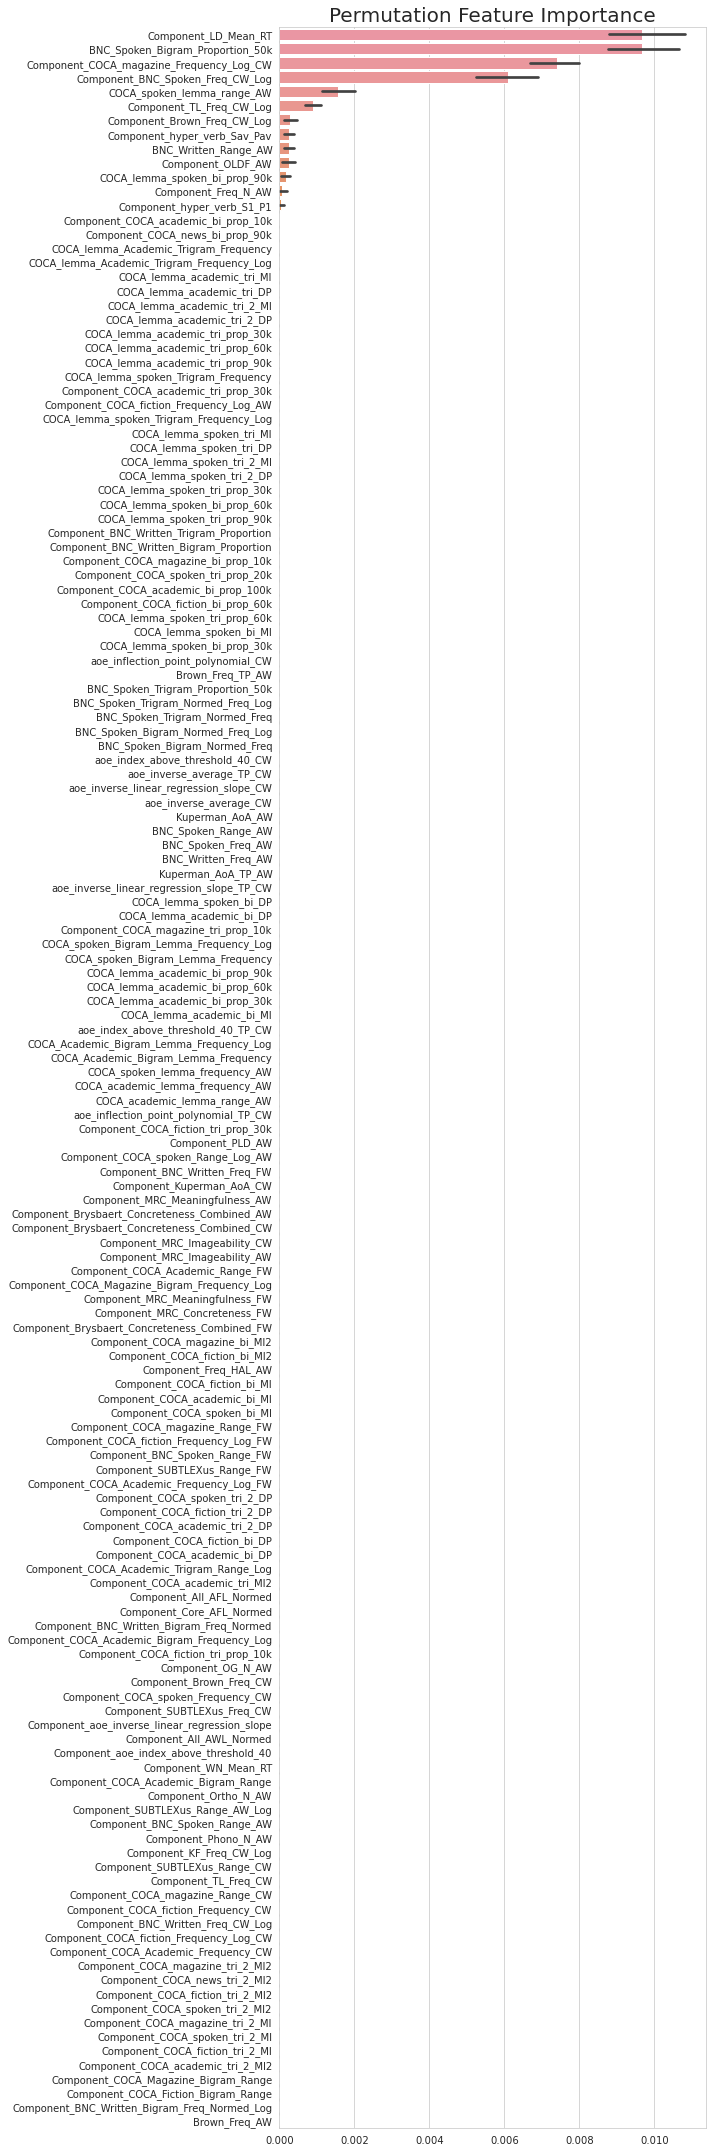

In [28]:
plt.figure(figsize=(10, 30))
sb.barplot(data=pfi_df, orient="h").set_title("Permutation Feature Importance",  fontsize=20);
plt.tight_layout()